In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import functools
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('ggplot')
%matplotlib inline

In [2]:
ALLEN_AI_RES_PATH = "../res/allenai/metadata.csv"

In [3]:
df_allen = pd.read_csv(ALLEN_AI_RES_PATH)[['source_x', 'title', 'abstract', 'publish_time', 'journal']]
df_allen = df_allen.fillna('')
df_allen['is_pr'] = ~df_allen.source_x.isin(['biorxiv', 'medrxiv']) # those sources are considered non-peer reviewed

print(len(df_allen.index))
df_allen.head(5)

44220


,source_x,title,abstract,publish_time,journal,is_pr
0,Elsevier,Intrauterine virus infections and congenital h...,Abstract The etiologic basis for the vast majo...,1972-12-31,American Heart Journal,True
1,Elsevier,Coronaviruses in Balkan nephritis,,1980-03-31,American Heart Journal,True
2,Elsevier,Cigarette smoking and coronary heart disease: ...,,1980-03-31,American Heart Journal,True
3,Elsevier,Clinical and immunologic studies in identical ...,"Abstract Middle-aged female identical twins, o...",1973-08-31,The American Journal of Medicine,True
4,Elsevier,Epidemiology of community-acquired respiratory...,Abstract Upper respiratory tract infections ar...,1985-06-28,The American Journal of Medicine,True


In [4]:
def get_tfidf_vec(sr_str):
    tfidf = TfidfVectorizer(stop_words='english', min_df=.001, max_df=0.5)
    tfidf_data = tfidf.fit_transform(sr_str.values)
    return tfidf_data, tfidf

def get_avg_importance(tfidf_data, tfidf_vec):
    sum_counts = functools.reduce(lambda a,b: a+b, tfidf_data)
    word_freq = zip(tfidf_vec.get_feature_names(), sum_counts.A[0]/tfidf_data.shape[0])
    word_freq = sorted(word_freq, key=lambda x:x[1], reverse=True)
    df_imp = pd.DataFrame(word_freq, columns=['term', 'relevance']).set_index('term')
    return df_imp

## Title based tf-idf

In [5]:
td, tfidf = get_tfidf_vec(df_allen.title)

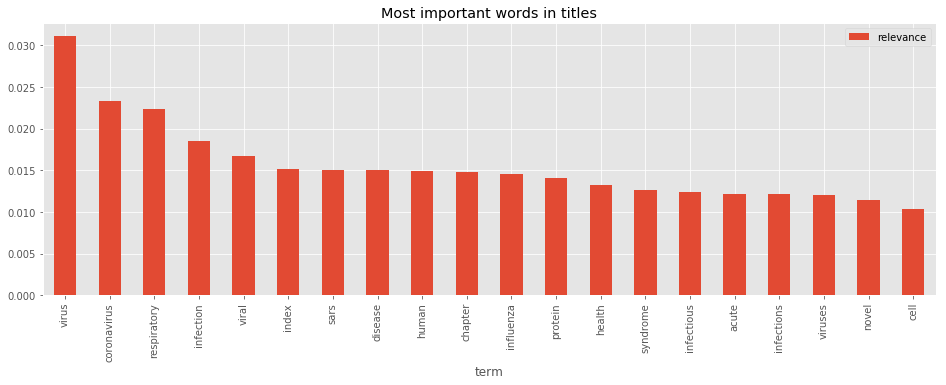

In [6]:
df_general = get_avg_importance(td,tfidf)
df_general.iloc[:20,].plot(kind='bar', title='Most important words in titles', figsize=(16,5))

In [7]:
unique_sources = df_allen.source_x.unique()
df_list = []
for i, source in enumerate(unique_sources):
    tfidf_data = td.tocsr()[np.where(df_allen.source_x==source)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['source'] = source
    df_list.append(df_res)

df_ti_source = pd.concat(df_list)
df_ti_source.head(5)

,relevance,source
term,,
index,0.033692,Elsevier
chapter,0.033691,Elsevier
virus,0.024372,Elsevier
respiratory,0.020164,Elsevier
coronavirus,0.018289,Elsevier


In [8]:
df_ti_rel = df_ti_source.set_index('source', append=True)
most_rel_terms = df_ti_source.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_terms

array(['covid', '19', 'coronavirus', '2019', 'novel', 'ncov', 'china',
       'pneumonia', 'outbreak', 'wuhan'], dtype=object)

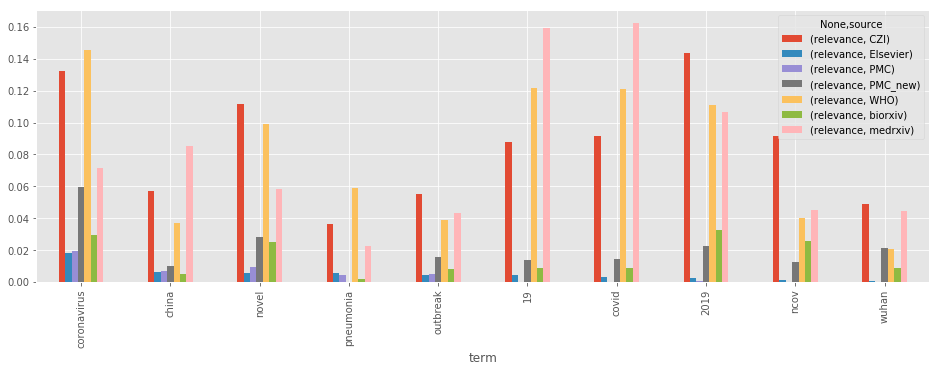

In [9]:
df_ti_rel[df_ti_rel.index.get_level_values(0).isin(most_rel_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [10]:
df_list = []
for i, val in enumerate([True, False]):
    tfidf_data = td.tocsr()[np.where(df_allen.is_pr == val)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['peer_reviewed'] = ('' if val else 'non-') + 'peer-reviewed'
    df_list.append(df_res)

df_ti_pr = pd.concat(df_list)
df_ti_pr.head(5)

,relevance,peer_reviewed
term,,
virus,0.031375,peer-reviewed
coronavirus,0.022781,peer-reviewed
respiratory,0.022780,peer-reviewed
infection,0.018581,peer-reviewed
viral,0.016781,peer-reviewed


In [11]:
df_ti_pr_rel = df_ti_pr.set_index('peer_reviewed', append=True)
most_rel_pr_terms = df_ti_pr.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_pr_terms

array(['covid', '19', '2019', 'coronavirus', 'novel', 'china', 'cov',
       'ncov', 'sars', 'virus'], dtype=object)

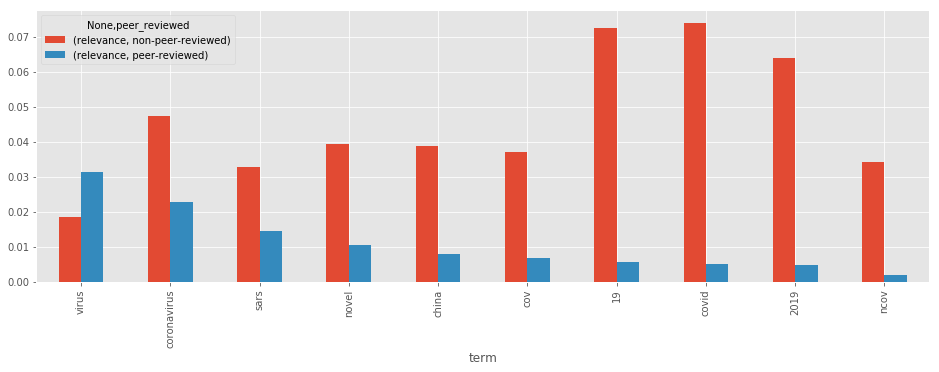

In [12]:
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(most_rel_pr_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [13]:
df_rel_dif = df_ti_pr_rel.reset_index().pivot(index='term',columns='peer_reviewed', values='relevance')
df_rel_dif['diff'] = df_rel_dif['non-peer-reviewed'] - df_rel_dif['peer-reviewed']
df_rel_dif['absdiff'] = np.abs(df_rel_dif['diff'])
df_rel_dif.sort_values(by='absdiff', ascending=False, inplace=True)
df_rel_dif.head(20)

peer_reviewed,non-peer-reviewed,peer-reviewed,diff,absdiff
term,,,,
covid,0.073881,0.005120,0.068761,0.068761
19,0.072682,0.005653,0.067029,0.067029
2019,0.064053,0.004901,0.059152,0.059152
ncov,0.034244,0.002126,0.032118,0.032118
china,0.038975,0.007983,0.030992,0.030992
cov,0.037095,0.006836,0.030259,0.030259
novel,0.039404,0.010696,0.028708,0.028708
coronavirus,0.047477,0.022781,0.024696,0.024696
wuhan,0.024054,0.001080,0.022974,0.022974


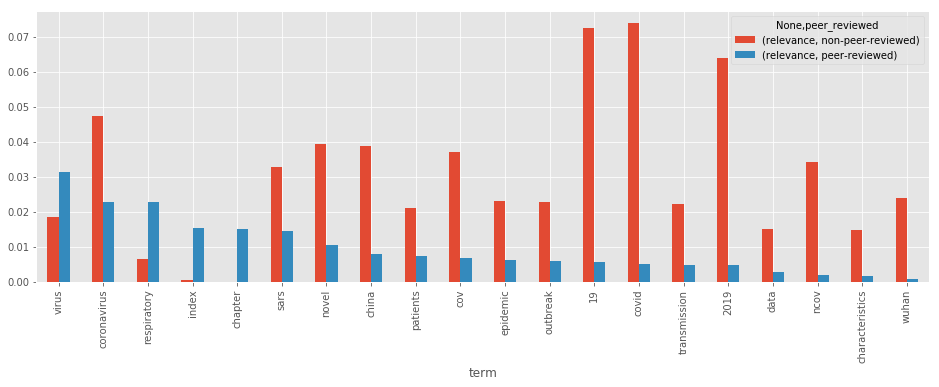

In [14]:
#excluded_list = ['virus', 'coronavirus', 'cov', '19','covid', '2019']
excluded_list = []
col_of_interest = [x for x in df_rel_dif.index[:20+len(excluded_list)] if x not in excluded_list]
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

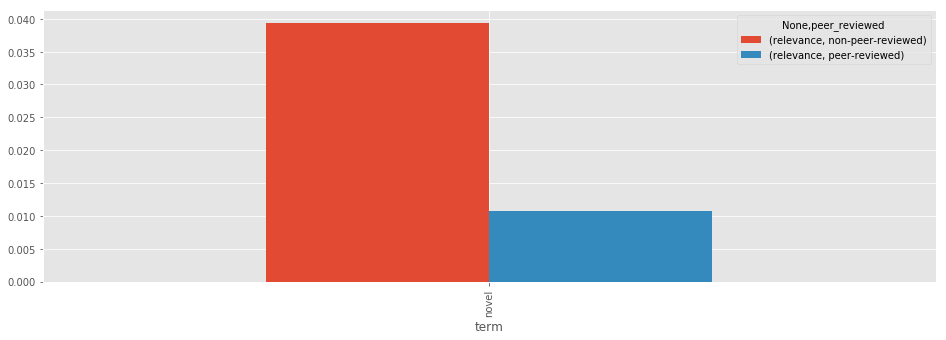

In [15]:
col_of_interest = ['novel', 'unprecedented', 'excellent', 'remarkable', 'exciting', 'brilliant']
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

## Abstract based tf-idf

In [17]:
td, tfidf = get_tfidf_vec(df_allen.abstract)

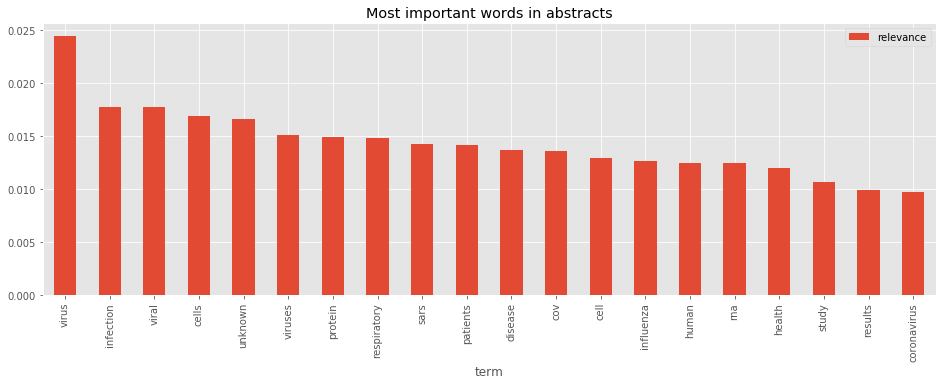

In [18]:
df_general = get_avg_importance(td,tfidf)
df_general.iloc[:20,].plot(kind='bar', title='Most important words in abstracts', figsize=(16,5))

In [19]:
unique_sources = df_allen.source_x.unique()
df_list = []
for i, source in enumerate(unique_sources):
    tfidf_data = td.tocsr()[np.where(df_allen.source_x==source)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['source'] = source
    df_list.append(df_res)

df_ti_source = pd.concat(df_list)
df_ti_source.head(5)

,relevance,source
term,,
unknown,0.034764,Elsevier
abstract,0.019847,Elsevier
virus,0.018552,Elsevier
viral,0.013812,Elsevier
sars,0.013757,Elsevier


In [20]:
df_ti_rel = df_ti_source.set_index('source', append=True)
most_rel_terms = df_ti_source.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_terms

array(['covid', '19', '2019', 'patients', 'cases', 'wuhan', 'china',
       'ncov', 'cov', 'coronavirus'], dtype=object)

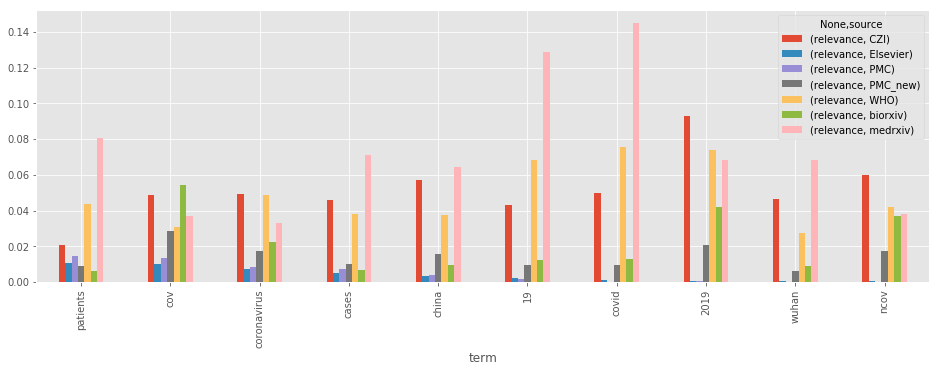

In [21]:
df_ti_rel[df_ti_rel.index.get_level_values(0).isin(most_rel_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [22]:
df_list = []
for i, val in enumerate([True, False]):
    tfidf_data = td.tocsr()[np.where(df_allen.is_pr == val)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['peer_reviewed'] = ('' if val else 'non-') + 'peer-reviewed'
    df_list.append(df_res)

df_ti_pr = pd.concat(df_list)
df_ti_pr.head(5)

,relevance,peer_reviewed
term,,
virus,0.024472,peer-reviewed
infection,0.017727,peer-reviewed
viral,0.017683,peer-reviewed
cells,0.016949,peer-reviewed
unknown,0.016934,peer-reviewed


In [23]:
df_ti_pr_rel = df_ti_pr.set_index('peer_reviewed', append=True)
most_rel_pr_terms = df_ti_pr.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_pr_terms

array(['covid', '19', '2019', 'cov', 'sars', 'patients', 'ncov', 'cases',
       'wuhan', 'china'], dtype=object)

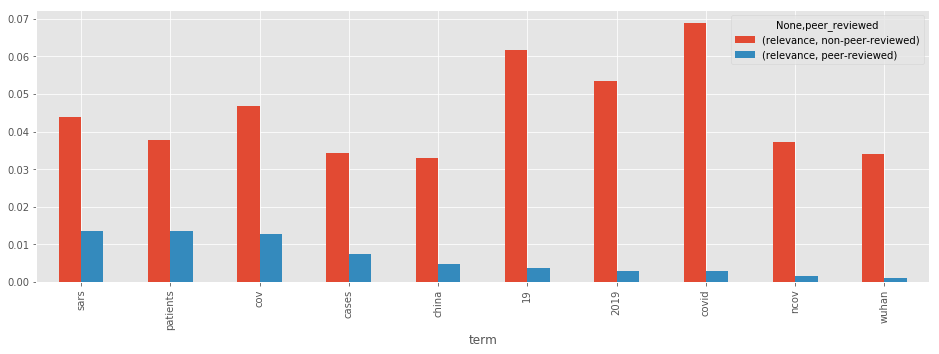

In [24]:
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(most_rel_pr_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [25]:
df_rel_dif = df_ti_pr_rel.reset_index().pivot(index='term',columns='peer_reviewed', values='relevance')
df_rel_dif['diff'] = df_rel_dif['non-peer-reviewed'] - df_rel_dif['peer-reviewed']
df_rel_dif['absdiff'] = np.abs(df_rel_dif['diff'])
df_rel_dif.sort_values(by='absdiff', ascending=False, inplace=True)
df_rel_dif.head(20)

peer_reviewed,non-peer-reviewed,peer-reviewed,diff,absdiff
term,,,,
covid,0.068820,0.002808,0.066013,0.066013
19,0.061747,0.003853,0.057895,0.057895
2019,0.053381,0.002960,0.050422,0.050422
ncov,0.037299,0.001705,0.035594,0.035594
cov,0.046791,0.012794,0.033998,0.033998
wuhan,0.034113,0.001184,0.032929,0.032929
sars,0.044008,0.013559,0.030448,0.030448
china,0.032946,0.004707,0.028239,0.028239
cases,0.034198,0.007375,0.026824,0.026824


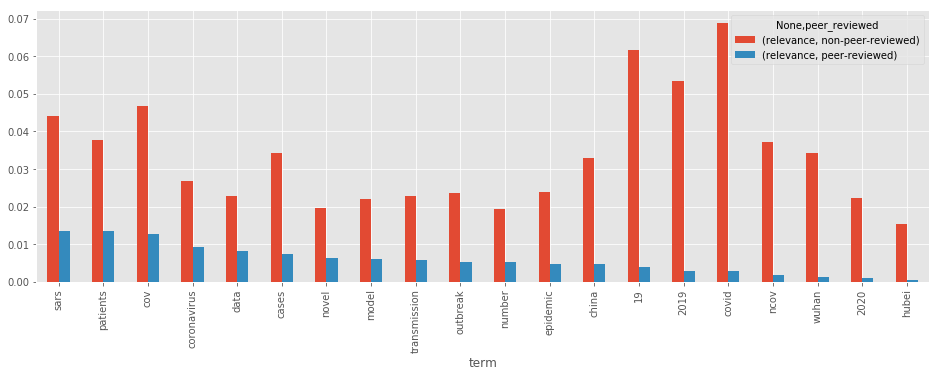

In [26]:
#excluded_list = ['virus', 'coronavirus', 'cov', '19','covid', '2019']
excluded_lists = []
col_of_interest = [x for x in df_rel_dif.index[:20+len(excluded_list)] if x not in excluded_list]
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

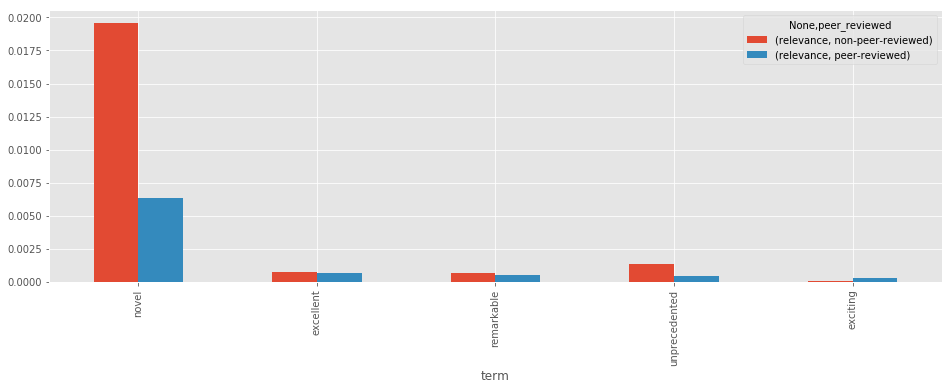

In [27]:
col_of_interest = ['novel', 'unprecedented', 'excellent', 'remarkable', 'exciting', 'brilliant']
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

In [28]:
df_allen[df_allen.abstract.str.contains('unknown')]

,source_x,title,abstract,publish_time,journal,is_pr
71,Elsevier,Putative papain-related thiol proteases of pos...,Abstract A computer-assisted comparative analy...,1991-08-19,FEBS Letters,True
147,Elsevier,Studies on the mechanism of protection from ac...,Abstract Previous studies have shown that mice...,1989-04-30,Journal of the Neurological Sciences,True
207,Elsevier,In vivo and in vitro models of demyelinating d...,Abstract Following inoculation of continuous c...,1978-07-15,Virology,True
258,Elsevier,Identification and characterization of a mouse...,"Abstract A unique subline of BALB/c mice, desi...",1985-05-31,Virology,True
381,Elsevier,Random nature of coronavirus RNA recombination...,Abstract RNA-RNA recombination is thought to o...,1991-11-30,Virology,True
409,Elsevier,Rice dwarf phytoreovirus segment S12 transcrip...,Abstract Sequence analysis revealed that rice ...,1992-12-31,Virology,True
638,Elsevier,Natural killer (NK) activity of porcine blood ...,Abstract Allogeneic PM/86 melanoma cells of Mu...,1991-08-31,Veterinary Immunology and Immunopathology,True
664,Elsevier,Immunity to transmissible gastroenteritis viru...,Abstract Despite the pioneering efforts to ide...,1994-10-31,Veterinary Immunology and Immunopathology,True
686,Elsevier,Murine coronavirus-induced encephalomyelitides...,Abstract The humoral intrathecal immune respon...,1986-08-31,Journal of Neuroimmunology,True
815,Elsevier,Antibody against adult diarrhoea rotavirus amo...,Abstract This paper deals with a method of usi...,1986-09-30,Journal of Virological Methods,True
